## CSCI 5654 - Linear Programming - Project

***
#### Team Members
#### 1. Ketan Ramesh
#### 2. Shreyas Gopalakrishna
***

## Vehicle Routing Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import random
import pulp
import gurobipy as gp
from gurobipy import GRB

## Vehicle Routing with capacity 
#### Link for paper: https://arxiv.org/pdf/1606.01935.pdf
#### The below code solves the capacited vehicle routing problem by following the methodology mentioned in the above cited paper.
#### The formulation is as follows:

## Capacity Vehicle Routing Problem - Model 1

Paper Link - [A generalized formulation for vehicle routing problems](https://arxiv.org/pdf/1606.01935.pdf)

<div align="justify">
The code provided below creates a <code>class</code> to frame and solve the Capacity Vehicle Routing Problem (CVRP) using the two-index flow formulation as mentioned in the paper. The formulation of the problem as a Mixed ILP is as follows:
</div>

$$
min \sum_{i=0}^{n+1} \sum_{j=0}^{n+1} c_{ij} x_{ij}
$$

$$
s.t. \sum_{j=1, j \neq i}^{n+1} x_{ij} = 1, i = 1, ..., n, - (1.1)
$$

$$
\sum_{i=0, i \neq h}^{n} x_{ih} - \sum_{j=1, j \neq h}^{n+1} x_{hj}
 = 0, h = 1, ..., n, - (1.2)
 $$

$$
\sum_{j=1}^{n} x_{0j} \leq K - (1.3)
$$

$$
y_j \geq y_i + q_j x_{ij} - Q(1 - x_{ij}), i, j = 0, ..., n+1, - (1.4)
$$

$$
q_i \leq y_i \leq Q, i = 0, ..., n+1, - (1.5)
$$

$$
x_{ij} = \{0, 1\}, i, j = 0, ..., n+1.
$$

where,

N customers are denoted by 1, 2, ... n. The depot is denoted as 0 and n+1 respectively.<br />
K = Number of vehicles.<br />
Q = Capacity of the vehicle.<br />
q<sub>i</sub> = Demand of customer i.<br />
c<sub>ij</sub> = Cost incurred on traveling from i to j.<br />

<b>Decision Variables:</b>
1. x<sub>ij</sub> = {<b>1</b>, if edge (i, j) present in any route. <b>0</b>, otherwise}. 

2. y<sub>j</sub> = Cummulative demand on route that visits node j. A continuous non-negative variable.

<div align="justify">
The objective is to minimize the sum of the distances of all routes that satisfy the given constraints. The constraint (1.1) is to ensure that all customer nodes are visited exactly once (each node <i>i</i> visits only one other node <i>j</i>). The constraint (1.2) ensures that if a node is visited, it must depart from the same node (node <i>h</i> visited by only one other node <i>i</i> and in turn visits only one other node <i>j</i>). The constraint (1.3) is used to limit number of different routes/number of vehicles from the depot. The constraints (1.4) and (1.5) is used to eliminate sub-tours and force each route to pass through/include the depot in it.
</div>
 

In [8]:
# PuLP class for vehicle routing

class CVRP_GUROBI:
	def __init__(self, numberOfCustomers, numberOfVehicles, capacityOfVehicle, demandOfCustomers, costMatrix):
		self.numberOfCustomers = numberOfCustomers
		self.numberOfVehicles  = numberOfVehicles
		self.capacityOfVehicle = capacityOfVehicle
		self.demandOfCustomers = demandOfCustomers
		self.costMatrix        = costMatrix
		self.initializeLP()
	
	def initializeLP(self):
		self.cvrpLP = gp.Model("CVRP")
		objective = None
		x,y = [], []
		constraint1 = None
		
		# objective function and variables
		for i in range(len(costMatrix)): #adding depot
			xTemp1 = []
			for j in range(len(costMatrix)):
				if(i != j):
					xTemp2 = self.cvrpLP.addVar(name='x('+str(i)+','+str(j)+')', vtype=GRB.BINARY, lb=0, ub=1)
					xTemp1.append(xTemp2)
					objective += xTemp2 * costMatrix[i][j]
				else:
					xTemp1.append(None)
			x.append(xTemp1)
		self.cvrpLP.setObjective(objective, GRB.MINIMIZE) 
		
		for i in range(len(costMatrix)):
			y.append(self.cvrpLP.addVar(name='y'+str(i),vtype=GRB.CONTINUOUS, lb=0))
		
		
		# constraints
		# ensure that all customers are visited exactly once
		for i in range(1, len(costMatrix)-1): #adding depot
			constraint1 = None
			for j in range(1, len(costMatrix)):
				if(i != j):
					if(constraint1 == None):
						constraint1 = x[i][j]
					else:
						constraint1 = constraint1 + x[i][j]
			self.cvrpLP.addConstr(constraint1 == 1)
		
		# limits the maximum number of routes to the number of vehicles
		constraint2 = None
		for j in range(1, len(costMatrix)-1): #not include depot
			if(constraint2 == None):
				constraint2 = x[0][j]
			else:
				constraint2 = constraint2 + x[0][j]
		self.cvrpLP.addConstr(constraint2 <= self.numberOfVehicles)

		# limits the maximum number of routes to the number of vehicles
		# constraint2 = None
		# for j in range(1, len(costMatrix) - 1): #not include depot
		#     constraint2 += x[j][-1]
		# self.cvrpLP += constraint2 <= self.numberOfVehicles
		
		# ensure together that the vehicle capacity is not exceeded
		for i in range(len(costMatrix)):
			constarint3a, constarint3b  = None, None
			constarint3a = self.demandOfCustomers[i] <= y[i] 
			constarint3b = y[i] <= self.capacityOfVehicle
			self.cvrpLP.addConstr(constarint3a)
			self.cvrpLP.addConstr(constarint3b)
		
		# ensure together that the vehicle capacity is not exceeded
		for i in range(len(costMatrix)): #adding depot
			for j in range(len(costMatrix)):
				constraint4 = None
				if(i != j):
					constraint4 = y[j] >= y[i] + self.demandOfCustomers[j]*x[i][j] - self.capacityOfVehicle*(1-x[i][j])
					self.cvrpLP.addConstr(constraint4)
		
		#guarantee the correct flow of vehicles through the arcs, by stating that if a vehicle arrives to a node
		#then it must depart from this node
		for h in range(1, len(costMatrix)-1):
			constraint5a, constraint5b = None, None
			for i in range(0, len(costMatrix)-1):
				if(i != h):
					if(constraint5a == None):
						constraint5a = x[i][h]
					else:
						constraint5a = constraint5a + x[i][h]
			for j in range(1, len(costMatrix)):
				if(j != h):
					if(constraint5b == None):
						constraint5b = x[h][j]
					else:
						constraint5b = constraint5b + x[h][j]
			self.cvrpLP.addConstr(constraint5a - constraint5b == 0)
		
		# print(self.cvrpLP)
		
	def solve(self):
		status = self.cvrpLP.optimize()
		print(status)
	
	def getResult(self):
		print("Objective value: ", self.cvrpLP.ObjVal)
		for v in self.cvrpLP.getVars():
			print(v.varName, " = ", v.x)
		return self.cvrpLP

## TESTING - RANDOM DATASET

In [9]:
numberOfCustomers = 5
capacityOfVehicle = 10
numberOfVehicles = 3
C = [i for i in range(1, numberOfCustomers+1)] #set of customers
V = [0] + C + [numberOfCustomers+1] #depot + customer nodes
demandOfCustomers = {1: 1, 2: 5, 3: 8, 4: 5, 5: 5, 0: 0, 6: 0}
# demandOfCustomers[0] = 0
# demandOfCustomers[numberOfCustomers+1] = 0

# Creating random coordinates
xCoordinates = [30, 20, 10, 10, 40, 50, 30]
yCoordinates = [30, 40, 45, 30, 10, 30, 30]

# Cost matrix
costMatrix = np.ndarray(shape=(len(V),len(V)))
for i in range(len(V)):
    for j in range(len(V)):
        if(i == 0 and j == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(j == 0 and i == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(i!=j):
            costMatrix[i][j] = int(distance.euclidean([xCoordinates[i],yCoordinates[i]], [xCoordinates[j],yCoordinates[j]]))
        else:
            costMatrix[i][j] = 0
print(costMatrix)
print(demandOfCustomers)

[[ 0. 14. 25. 20. 22. 20.  0.]
 [14.  0. 11. 14. 36. 31. 14.]
 [25. 11.  0. 15. 46. 42. 25.]
 [20. 14. 15.  0. 36. 40. 20.]
 [22. 36. 46. 36.  0. 22. 22.]
 [20. 31. 42. 40. 22.  0. 20.]
 [ 0. 14. 25. 20. 22. 20.  0.]]
{1: 1, 2: 5, 3: 8, 4: 5, 5: 5, 0: 0, 6: 0}


In [10]:
lp = CVRP_GUROBI(numberOfCustomers, numberOfVehicles, capacityOfVehicle, demandOfCustomers, costMatrix)
lp.solve()
result = lp.getResult()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 67 rows, 49 columns and 220 nonzeros
Model fingerprint: 0x14c26846
Variable types: 7 continuous, 42 integer (42 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 154.0000000
Presolve removed 48 rows and 30 columns
Presolve time: 0.00s
Presolved: 19 rows, 19 columns, 82 nonzeros
Variable types: 5 continuous, 14 integer (14 binary)

Root relaxation: cutoff, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0       154.00000  154.00000  0.00%     -    0s

Explored 0 nodes (7 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 1: 154 

Optimal solution found (to

In [13]:
# Use output to get path
# gets variables as (x,y) coordinates
variables = []
for v in result.getVars():
    if('x' in v.varName and v.x == 1):
        # print(v.name, " = ", v.varValue)
        temp = (v.varName.split('(')[1].split(')')[0].split(','))
        variables.append((int(temp[0]),int(temp[1])))
# print(variables)

# recursive calls for getting the path
def recursiveList(start, L, X):
    for item in L:
        if(item[0] == start):
            X.append(item)
            return recursiveList(item[1], L, X)
    return X

pathList = []
setList = []
start = 0
for v in variables:
    if(v[0] == start):
        path = recursiveList(v[1], variables, [v])
        print(path)
        pathList.append(path)
        set1 = []
        for i in path:
            set1.append(i[0])
            set1.append(i[1])
        setList.append(list(set(set1)))

[(0, 1), (1, 2), (2, 6)]
[(0, 3), (3, 6)]
[(0, 5), (5, 4), (4, 6)]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/Users/shreyas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


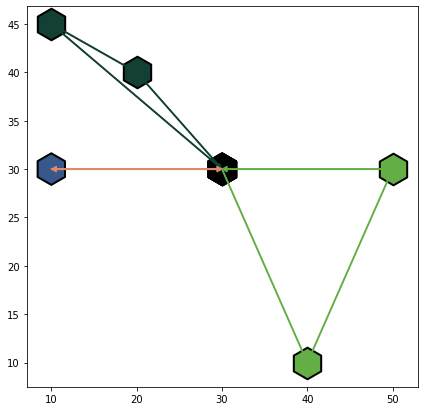

In [14]:
# Visualization
plt.figure(figsize=(7,7))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

coordinateList = []
for s in setList:
    coordinate = []
    for j in s:
        coordinate.append([float(xCoordinates[j]), float(yCoordinates[j])])
    coordinateList.append(coordinate)
# print(coordinateList)

def addToPlot(L):
    x_val = [x[0] for x in L]
    y_val = [x[1] for x in L]

    r = random.random()
    b = random.random()
    g = random.random()
    newColor = (r, g, b)
    
    plt.scatter(x_val,y_val, c=newColor, edgecolor='black', linewidth=2, s=1000, marker='h')
    ax = plt.axes()
    
    length = len(L)-1
    
    for i in range(length):
        ax.arrow(L[i][0],  #x1
                    L[i][1],  # y1
                    L[i+1][0]-L[i][0], # x2 - x1
                    L[i+1][1]-L[i][1], # y2 - y1
                    width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
                    )
    
    # ax.arrow(L[-1][0],  #x1
    #                 L[-1][1],  # y1
    #                 L[0][0]-L[-1][0], # x2 - x1
    #                 L[0][1]-L[-1][1], # y2 - y1
    #                 width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
    #                 )
for i in range(len(coordinateList)):
    addToPlot(coordinateList[i])
plt.scatter(coordinateList[0][0][0],coordinateList[0][0][1], c='black', edgecolor='black', linewidth='2', s=1000, marker='h')
plt.show()

## TESTING WITH PRE_DEFINED DATA N=15
## P-n16-k8.vrp - Augerat et al. Set - P

In [15]:
# Data Source: 
numberOfCustomers = 15
capacityOfVehicle = 35
numberOfVehicles = 8
C = [i for i in range(1, numberOfCustomers+1)] #set of customers
V = [0] + C + [numberOfCustomers+1] #depot + customer nodes
demandOfCustomers = {0:0,1:19,2:30,3:16,4:23,5:11,6:31,7:15,8:28,9:8,10:8,11:7,12:14,13:6,14:19,15:11}
# demandOfCustomers[0] = 0
demandOfCustomers[numberOfCustomers+1] = 0

xCoordinates = [30,37,49,52,31,52,42,52,57,62,42,27,43,58,58,37,30]
yCoordinates = [40,52,49,64,62,33,41,41,58,42,57,68,67,48,27,69,40]

# Cost matrix
costMatrix = np.ndarray(shape=(len(V),len(V)))
for i in range(len(V)):
    for j in range(len(V)):
        if(i == 0 and j == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(j == 0 and i == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(i!=j):
            costMatrix[i][j] = int(distance.euclidean([xCoordinates[i],yCoordinates[i]], [xCoordinates[j],yCoordinates[j]]))
        else:
            costMatrix[i][j] = 0
costMatrix

array([[ 0., 13., 21., 32., 22., 23., 12., 22., 32., 32., 20., 28., 29.,
        29., 30., 29.,  0.],
       [13.,  0., 12., 19., 11., 24., 12., 18., 20., 26.,  7., 18., 16.,
        21., 32., 17., 13.],
       [21., 12.,  0., 15., 22., 16., 10.,  8., 12., 14., 10., 29., 18.,
         9., 23., 23., 21.],
       [32., 19., 15.,  0., 21., 31., 25., 23.,  7., 24., 12., 25.,  9.,
        17., 37., 15., 32.],
       [22., 11., 22., 21.,  0., 35., 23., 29., 26., 36., 12.,  7., 13.,
        30., 44.,  9., 22.],
       [23., 24., 16., 31., 35.,  0., 12.,  8., 25., 13., 26., 43., 35.,
        16.,  8., 39., 23.],
       [12., 12., 10., 25., 23., 12.,  0., 10., 22., 20., 16., 30., 26.,
        17., 21., 28., 12.],
       [22., 18.,  8., 23., 29.,  8., 10.,  0., 17., 10., 18., 36., 27.,
         9., 15., 31., 22.],
       [32., 20., 12.,  7., 26., 25., 22., 17.,  0., 16., 15., 31., 16.,
        10., 31., 22., 32.],
       [32., 26., 14., 24., 36., 13., 20., 10., 16.,  0., 25., 43., 31.,
         

In [17]:
lp = CVRP_GUROBI(numberOfCustomers, numberOfVehicles, capacityOfVehicle, demandOfCustomers, costMatrix)
lp.solve()
result = lp.getResult()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 337 rows, 289 columns and 1540 nonzeros
Model fingerprint: 0x464e5be6
Variable types: 17 continuous, 272 integer (272 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [6e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 186 rows and 130 columns
Presolve time: 0.00s
Presolved: 151 rows, 159 columns, 1316 nonzeros
Variable types: 13 continuous, 146 integer (146 binary)

Root relaxation: objective 2.482569e+02, 103 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  248.25694    0   37          -  248.25694      -     -    0s
H    0     0                     491.0000000  248.25694  49.4%     -    0s
H    0     0                     477.0000000  248.25694  48.0%     -    0s
H    0     0          

In [18]:
# Use output to get path
# gets variables as (x,y) coordinates
variables = []
for v in result.getVars():
    if('x' in v.varName and v.x == 1):
        # print(v.name, " = ", v.varValue)
        temp = (v.varName.split('(')[1].split(')')[0].split(','))
        variables.append((int(temp[0]),int(temp[1])))
# print(variables)

# recursive calls for getting the path
def recursiveList(start, L, X):
    for item in L:
        if(item[0] == start):
            X.append(item)
            return recursiveList(item[1], L, X)
    return X

pathList = []
setList = []
start = 0
for v in variables:
    if(v[0] == start):
        path = recursiveList(v[1], variables, [v])
        print(path)
        pathList.append(path)
        set1 = []
        for i in path:
            set1.append(i[0])
            set1.append(i[1])
        a = list(set(set1))
        setList.append(sorted(a))
print(setList)

[(0, 1), (1, 16)]
[(0, 2), (2, 16)]
[(0, 3), (3, 9), (9, 5), (5, 16)]
[(0, 6), (6, 16)]
[(0, 10), (10, 12), (12, 15), (15, 16)]
[(0, 11), (11, 4), (4, 16)]
[(0, 13), (13, 8), (8, 16)]
[(0, 14), (14, 7), (7, 16)]
[[0, 1, 16], [0, 2, 16], [0, 3, 5, 9, 16], [0, 6, 16], [0, 10, 12, 15, 16], [0, 4, 11, 16], [0, 8, 13, 16], [0, 7, 14, 16]]


/Users/shreyas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like

[[30.0, 40.0], [37.0, 52.0], [30.0, 40.0]]
[[30.0, 40.0], [49.0, 49.0], [30.0, 40.0]]
[[30.0, 40.0], [52.0, 64.0], [52.0, 33.0], [62.0, 42.0], [30.0, 40.0]]
[[30.0, 40.0], [42.0, 41.0], [30.0, 40.0]]
[[30.0, 40.0], [42.0, 57.0], [43.0, 67.0], [37.0, 69.0], [30.0, 40.0]]
[[30.0, 40.0], [31.0, 62.0], [27.0, 68.0], [30.0, 40.0]]
[[30.0, 40.0], [57.0, 58.0], [58.0, 48.0], [30.0, 40.0]]
[[30.0, 40.0], [52.0, 41.0], [58.0, 27.0], [30.0, 40.0]]


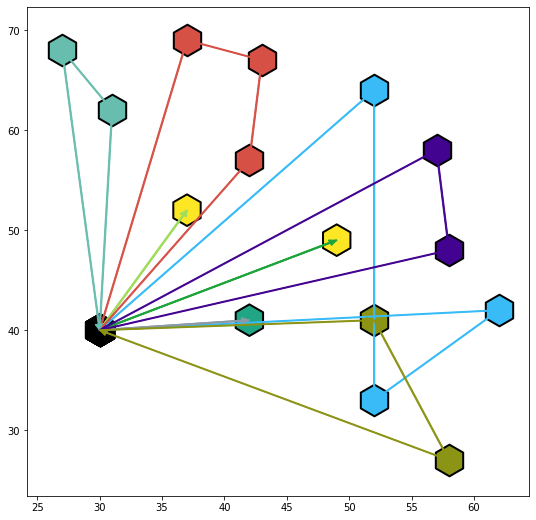

In [19]:
# Visualization
plt.figure(figsize=(9,9))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

coordinateList = []
for s in setList:
    coordinate = []
    for j in s:
        coordinate.append([float(xCoordinates[j]), float(yCoordinates[j])])
    coordinateList.append(coordinate)
# print(coordinateList)

def addToPlot(L):
    x_val = [x[0] for x in L]
    y_val = [x[1] for x in L]

    r = random.random()
    b = random.random()
    g = random.random()
    newColor = (r, g, b)
    
    plt.scatter(x_val,y_val, c=newColor, edgecolor='black', linewidth=2, s=1000, marker='h')
    ax = plt.axes()
    
    length = len(L)-1
    
    for i in range(length):
        ax.arrow(L[i][0],  #x1
                    L[i][1],  # y1
                    L[i+1][0]-L[i][0], # x2 - x1
                    L[i+1][1]-L[i][1], # y2 - y1
                    width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
                    )
    
    # ax.arrow(L[-1][0],  #x1
    #                 L[-1][1],  # y1
    #                 L[0][0]-L[-1][0], # x2 - x1
    #                 L[0][1]-L[-1][1], # y2 - y1
    #                 width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
    #                 )
for i in range(len(coordinateList)):
    print(coordinateList[i])
    addToPlot(coordinateList[i])
plt.scatter(coordinateList[0][0][0],coordinateList[0][0][1], c='black', edgecolor='black', linewidth='2', s=1000, marker='h')
plt.show()

## TESTING WITH PRE_DEFINED DATA N=20
## P-n20-k2.vrp - Augerat et al. Set - P

In [23]:
numberOfCustomers = 19
capacityOfVehicle = 160
numberOfVehicles = 2
C = [i for i in range(1, numberOfCustomers+1)] #set of customers
V = [0] + C + [numberOfCustomers+1] #depot + customer nodes
demandOfCustomers = [0, 19, 30, 16, 23, 11, 31, 15, 28, 8, 8, 7, 14, 6, 19, 11, 26, 17, 6, 15, 0]
# demandOfCustomers[0] = 0
# demandOfCustomers[numberOfCustomers+1] = 0

xCoordinates = [30, 37, 49, 52, 31, 52, 42, 52, 57, 62, 42, 27, 43, 58, 58, 37, 61, 62, 63, 45, 30]
yCoordinates = [40, 52, 49, 64, 62, 33, 41, 41, 58, 42, 57, 68, 67, 48, 27, 69, 33, 63, 69, 35, 40]

# Cost matrix
costMatrix = np.ndarray(shape=(len(V),len(V)))
for i in range(len(V)):
    for j in range(len(V)):
        if(i == 0 and j == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(j == 0 and i == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(i!=j):
            costMatrix[i][j] = int(distance.euclidean([xCoordinates[i],yCoordinates[i]], [xCoordinates[j],yCoordinates[j]]))
        else:
            costMatrix[i][j] = 0
costMatrix

array([[ 0., 13., 21., 32., 22., 23., 12., 22., 32., 32., 20., 28., 29.,
        29., 30., 29., 31., 39., 43., 15.,  0.],
       [13.,  0., 12., 19., 11., 24., 12., 18., 20., 26.,  7., 18., 16.,
        21., 32., 17., 30., 27., 31., 18., 13.],
       [21., 12.,  0., 15., 22., 16., 10.,  8., 12., 14., 10., 29., 18.,
         9., 23., 23., 20., 19., 24., 14., 21.],
       [32., 19., 15.,  0., 21., 31., 25., 23.,  7., 24., 12., 25.,  9.,
        17., 37., 15., 32., 10., 12., 29., 32.],
       [22., 11., 22., 21.,  0., 35., 23., 29., 26., 36., 12.,  7., 13.,
        30., 44.,  9., 41., 31., 32., 30., 22.],
       [23., 24., 16., 31., 35.,  0., 12.,  8., 25., 13., 26., 43., 35.,
        16.,  8., 39.,  9., 31., 37.,  7., 23.],
       [12., 12., 10., 25., 23., 12.,  0., 10., 22., 20., 16., 30., 26.,
        17., 21., 28., 20., 29., 35.,  6., 12.],
       [22., 18.,  8., 23., 29.,  8., 10.,  0., 17., 10., 18., 36., 27.,
         9., 15., 31., 12., 24., 30.,  9., 22.],
       [32., 20., 12.,  

In [24]:
lp = CVRP_GUROBI(numberOfCustomers, numberOfVehicles, capacityOfVehicle, demandOfCustomers, costMatrix)
lp.solve()
result = lp.getResult()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 501 rows, 441 columns and 2404 nonzeros
Model fingerprint: 0xa6550ad2
Variable types: 21 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [6e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 120 rows and 42 columns
Presolve time: 0.01s
Presolved: 381 rows, 399 columns, 1767 nonzeros
Variable types: 19 continuous, 380 integer (380 binary)

Root relaxation: objective 1.342688e+02, 69 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  134.26875    0   35          -  134.26875      -     -    0s
     0     0  153.00000    0   38          -  153.00000      -     -    0s
     0     0  153.00000    0   38          -  153.00000      -     -    0s
     0     0  153.00000 

 2034328 543283  200.01164   52   19  211.00000  188.79241  10.5%  11.7  370s
 2052055 544588  202.50668   58   25  211.00000  188.87295  10.5%  11.7  375s
 2068624 545792  206.90601   46   28  211.00000  188.94611  10.5%  11.7  380s
 2092585 545727  196.12447   59   20  211.00000  189.00000  10.4%  11.7  385s
 2117205 547902 infeasible   79       211.00000  189.07969  10.4%  11.7  390s
 2140746 549676  206.65649   50   24  211.00000  189.17532  10.3%  11.7  395s
 2162324 551219  209.87835   53   17  211.00000  189.26768  10.3%  11.7  400s
 2185837 552827  201.79934   53   17  211.00000  189.36758  10.3%  11.7  405s
 2207567 554277     cutoff   77       211.00000  189.46080  10.2%  11.8  410s
 2227004 555615  195.20563   53   32  211.00000  189.53717  10.2%  11.8  415s
 2249082 557079  191.00498   46   19  211.00000  189.62673  10.1%  11.8  420s
 2270272 558124  198.70379   48   18  211.00000  189.70956  10.1%  11.8  425s
 2289420 559521  208.56923   53   17  211.00000  189.78562  10.1

 4466256 577862  201.23592   53   28  211.00000  196.54896  6.85%  12.1  900s
 4496738 576205  204.68680   50   25  211.00000  196.63718  6.81%  12.1  905s
 4527001 574398  201.41480   98   18  211.00000  196.72598  6.76%  12.1  910s
 4557646 572826  207.53382   48   24  211.00000  196.80879  6.73%  12.1  915s
 4587935 570719  201.49536   79   25  211.00000  196.89471  6.68%  12.1  920s
 4620109 568167  203.01452   51   26  211.00000  196.98746  6.64%  12.1  925s
 4645216 567500     cutoff   51       211.00000  197.00000  6.64%  12.1  930s
 4670044 565507 infeasible   47       211.00000  197.06401  6.60%  12.1  935s
 4696995 563872  206.12705   56   25  211.00000  197.13883  6.57%  12.1  940s
 4723626 561934  205.74538   60   20  211.00000  197.21255  6.53%  12.1  945s
 4755402 559225     cutoff   80       211.00000  197.30380  6.49%  12.1  950s
 4785055 556732 infeasible   78       211.00000  197.38795  6.45%  12.1  955s
 4816133 554193  205.43254   53   15  211.00000  197.47700  6.41

x(16,1)  =  0.0
x(16,2)  =  0.0
x(16,3)  =  0.0
x(16,4)  =  0.0
x(16,5)  =  0.0
x(16,6)  =  0.0
x(16,7)  =  0.0
x(16,8)  =  0.0
x(16,9)  =  1.0
x(16,10)  =  0.0
x(16,11)  =  0.0
x(16,12)  =  0.0
x(16,13)  =  0.0
x(16,14)  =  0.0
x(16,15)  =  0.0
x(16,17)  =  0.0
x(16,18)  =  0.0
x(16,19)  =  0.0
x(16,20)  =  0.0
x(17,0)  =  0.0
x(17,1)  =  0.0
x(17,2)  =  0.0
x(17,3)  =  0.0
x(17,4)  =  0.0
x(17,5)  =  0.0
x(17,6)  =  0.0
x(17,7)  =  0.0
x(17,8)  =  0.0
x(17,9)  =  0.0
x(17,10)  =  0.0
x(17,11)  =  0.0
x(17,12)  =  0.0
x(17,13)  =  0.0
x(17,14)  =  0.0
x(17,15)  =  0.0
x(17,16)  =  0.0
x(17,18)  =  1.0
x(17,19)  =  0.0
x(17,20)  =  0.0
x(18,0)  =  0.0
x(18,1)  =  0.0
x(18,2)  =  0.0
x(18,3)  =  1.0
x(18,4)  =  0.0
x(18,5)  =  0.0
x(18,6)  =  0.0
x(18,7)  =  0.0
x(18,8)  =  0.0
x(18,9)  =  0.0
x(18,10)  =  0.0
x(18,11)  =  0.0
x(18,12)  =  0.0
x(18,13)  =  0.0
x(18,14)  =  0.0
x(18,15)  =  0.0
x(18,16)  =  0.0
x(18,17)  =  0.0
x(18,19)  =  0.0
x(18,20)  =  0.0
x(19,0)  =  0.0
x(19,1)  =

In [25]:
# Use output to get path
# gets variables as (x,y) coordinates
variables = []
for v in result.getVars():
    if('x' in v.varName and v.x == 1):
        # print(v.name, " = ", v.varValue)
        temp = (v.varName.split('(')[1].split(')')[0].split(','))
        variables.append((int(temp[0]),int(temp[1])))
# print(variables)

# recursive calls for getting the path
def recursiveList(start, L, X):
    for item in L:
        if(item[0] == start):
            X.append(item)
            return recursiveList(item[1], L, X)
    return X

pathList = []
setList = []
start = 0
for v in variables:
    if(v[0] == start):
        path = recursiveList(v[1], variables, [v])
        print(path)
        pathList.append(path)
        set1 = []
        for i in path:
            set1.append(i[0])
            set1.append(i[1])
        a = list(set(set1))
        setList.append(sorted(a))
print(setList)

[(0, 6), (6, 13), (13, 8), (8, 17), (17, 18), (18, 3), (3, 12), (12, 15), (15, 11), (11, 4), (4, 20)]
[(0, 19), (19, 5), (5, 14), (14, 16), (16, 9), (9, 7), (7, 2), (2, 10), (10, 1), (1, 20)]
[[0, 3, 4, 6, 8, 11, 12, 13, 15, 17, 18, 20], [0, 1, 2, 5, 7, 9, 10, 14, 16, 19, 20]]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/Users/shreyas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[[30.0, 40.0], [52.0, 64.0], [31.0, 62.0], [42.0, 41.0], [57.0, 58.0], [27.0, 68.0], [43.0, 67.0], [58.0, 48.0], [37.0, 69.0], [62.0, 63.0], [63.0, 69.0], [30.0, 40.0]]
[[30.0, 40.0], [37.0, 52.0], [49.0, 49.0], [52.0, 33.0], [52.0, 41.0], [62.0, 42.0], [42.0, 57.0], [58.0, 27.0], [61.0, 33.0], [45.0, 35.0], [30.0, 40.0]]


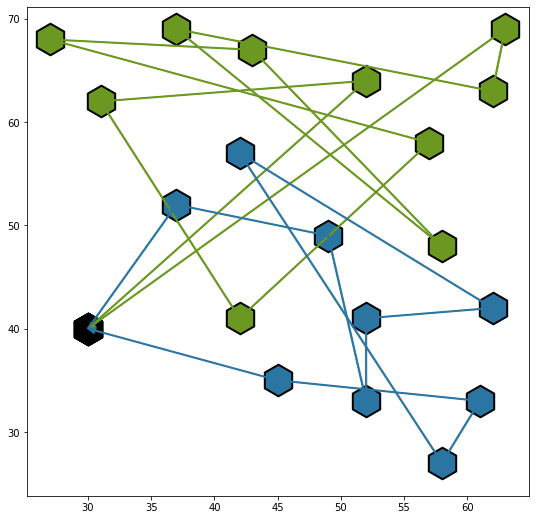

In [26]:
# Visualization
plt.figure(figsize=(9,9))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

coordinateList = []
for s in setList:
    coordinate = []
    for j in s:
        coordinate.append([float(xCoordinates[j]), float(yCoordinates[j])])
    coordinateList.append(coordinate)
# print(coordinateList)

def addToPlot(L):
    x_val = [x[0] for x in L]
    y_val = [x[1] for x in L]

    r = random.random()
    b = random.random()
    g = random.random()
    newColor = (r, g, b)
    
    plt.scatter(x_val,y_val, c=newColor, edgecolor='black', linewidth=2, s=1000, marker='h')
    ax = plt.axes()
    
    length = len(L)-1
    
    for i in range(length):
        ax.arrow(L[i][0],  #x1
                    L[i][1],  # y1
                    L[i+1][0]-L[i][0], # x2 - x1
                    L[i+1][1]-L[i][1], # y2 - y1
                    width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
                    )
    
    # ax.arrow(L[-1][0],  #x1
    #                 L[-1][1],  # y1
    #                 L[0][0]-L[-1][0], # x2 - x1
    #                 L[0][1]-L[-1][1], # y2 - y1
    #                 width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
    #                 )
for i in range(len(coordinateList)):
    print(coordinateList[i])
    addToPlot(coordinateList[i])
plt.scatter(coordinateList[0][0][0],coordinateList[0][0][1], c='black', edgecolor='black', linewidth='2', s=1000, marker='h')
plt.show()

## TESTING WITH PRE_DEFINED DATA N=32
## A-n32-k5.vrp - Augerat et al. Set - A


In [20]:
#N-31 CVRP:
numberOfCustomers = 31
capacityOfVehicle = 100
numberOfVehicles = 5
C = [i for i in range(1, numberOfCustomers+1)] #set of customers
V = [0] + C + [numberOfCustomers+1] #depot + customer nodes
demandOfCustomers = {0:0,1:19,2:21,3:6,4:19,5:7,6:12,7:16,8:6,9:16,10:8,11:14,12:21,13:16,14:3,15:22,16:18,17:19,18:1,19:24,20:8,21:12,22:4,23:8,24:24,25:24,26:2,27:20,28:15,29:2,30:14,31:9}
# demandOfCustomers[0] = 0
demandOfCustomers[numberOfCustomers+1] = 0


xCoordinates = [82,96,50,49,13,29,58,84,14,2,3,5,98,84,61,1,88,91,19,93,50,98,5,42,61,9,80,57,23,20,85,98,82]
yCoordinates = [76,44,5,8,7,89,30,39,24,39,82,10,52,25,59,65,51,2,32,3,93,14,42,9,62,97,55,69,15,70,60,5,76]
# Cost matrix
costMatrix = np.ndarray(shape=(len(V),len(V)))
for i in range(len(V)):
    for j in range(len(V)):
        if(i == 0 and j == len(V)-1):
            costMatrix[i][j] = 0
            continue
        if(j == 0 and i == len(V)-1):
            costMatrix[i][j] = 0
            continue
        if(i!=j):
            costMatrix[i][j] = int(distance.euclidean([xCoordinates[i],yCoordinates[i]], [xCoordinates[j],yCoordinates[j]]))
        else:
            costMatrix[i][j] = 0
costMatrix

array([[ 0., 34., 77., ..., 16., 72.,  0.],
       [34.,  0., 60., ..., 19., 39., 34.],
       [77., 60.,  0., ..., 65., 48., 77.],
       ...,
       [16., 19., 65., ...,  0., 56., 16.],
       [72., 39., 48., ..., 56.,  0., 72.],
       [ 0., 34., 77., ..., 16., 72.,  0.]])

In [21]:
lp = CVRP_GUROBI(numberOfCustomers, numberOfVehicles, capacityOfVehicle, demandOfCustomers, costMatrix)
lp.solve()
result = lp.getResult()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 1185 rows, 1089 columns and 6148 nonzeros
Model fingerprint: 0xf3e5f92b
Variable types: 33 continuous, 1056 integer (1056 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 192 rows and 66 columns
Presolve time: 0.01s
Presolved: 993 rows, 1023 columns, 4743 nonzeros
Variable types: 31 continuous, 992 integer (992 binary)

Root relaxation: objective 3.528700e+02, 117 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  352.87000    0   50          -  352.87000      -     -    0s
H    0     0                    1348.0000000  352.87000  73.8%     -    0s
     0     0  399.23333    0   70 1348.00000  399.23333  70.4%     -    0s
H    0     0      

 478357 389829  559.75224   95   62  780.00000  464.22333  40.5%  32.6  330s
 484800 395162  749.08700  146   50  780.00000  464.34503  40.5%  32.6  335s
 491342 400926  774.55926  113   35  780.00000  464.43171  40.5%  32.7  340s
 497710 406495  773.93801   99   37  780.00000  464.57686  40.4%  32.7  345s
 504430 411984  746.09520  130   51  780.00000  464.70152  40.4%  32.7  350s
 513062 419208  587.23351  113   44  780.00000  464.83244  40.4%  32.8  355s
 522129 426804  499.66131   46   62  780.00000  465.00060  40.4%  32.8  360s
 526393 430688  568.95844   62   56  780.00000  465.07059  40.4%  32.8  365s
 532841 436303  484.38147   42   72  780.00000  465.20665  40.4%  32.8  370s
 539507 442036  748.26867  128   44  780.00000  465.36791  40.3%  32.8  375s
 543921 445928  620.76662   71   50  780.00000  465.45183  40.3%  32.8  380s
 549569 450780  484.02055   45   71  780.00000  465.58964  40.3%  32.8  385s
 559041 458786  718.06610  103   45  780.00000  465.78264  40.3%  32.8  390s

 1289694 1055824  495.24900   45   61  777.00000  475.60847  38.8%  34.9  855s
 1295230 1060057  650.52533   59   58  777.00000  475.67350  38.8%  34.9  860s
 1301261 1064607  571.91217   55   61  777.00000  475.73392  38.8%  35.0  865s
 1307188 1069072  684.49867   73   62  777.00000  475.81648  38.8%  35.0  870s
 1314968 1075135  507.13318   43   62  777.00000  475.90072  38.8%  35.0  875s
 1321158 1080139  604.61563   75   49  777.00000  475.95806  38.7%  35.0  880s
 1327001 1084528  616.28419   43   63  777.00000  476.02558  38.7%  35.1  885s
 1334409 1090239  707.22739   60   48  777.00000  476.12551  38.7%  35.1  890s
 1341662 1096043  542.61024   51   66  777.00000  476.19845  38.7%  35.1  895s
 1347991 1100904  543.50663   47   70  777.00000  476.27841  38.7%  35.2  900s
 1353829 1105262  622.88632   80   60  777.00000  476.35663  38.7%  35.2  905s
 1361363 1110968  609.82687  174   56  777.00000  476.43890  38.7%  35.2  910s
 1367316 1115502  646.00971   72   47  777.00000  47

 1925100 1543549 infeasible  104       777.00000  481.23344  38.1%  37.5 1375s
 1932677 1549248  620.38642   64   57  777.00000  481.28539  38.1%  37.6 1380s
 1939800 1554711  769.86079   85   62  777.00000  481.33164  38.1%  37.6 1385s
 1946904 1560219  547.04556   54   58  777.00000  481.37666  38.0%  37.6 1390s
 1951815 1563953  522.64362   46   57  777.00000  481.41489  38.0%  37.6 1395s
 1958078 1569013  768.02862   91   42  777.00000  481.45585  38.0%  37.6 1400s
 1965842 1575019  593.21390   55   71  777.00000  481.50536  38.0%  37.7 1405s
 1973062 1580271  507.40018   40   55  777.00000  481.56380  38.0%  37.7 1410s
 1980551 1585946  650.97212   63   49  777.00000  481.60467  38.0%  37.7 1415s
 1986909 1590869 infeasible   66       777.00000  481.64111  38.0%  37.7 1420s
 1994578 1596936  764.39888   88   46  777.00000  481.68998  38.0%  37.7 1425s
 2001427 1602209  501.22938   50   64  777.00000  481.72879  38.0%  37.8 1430s
 2009370 1608401  672.87459   55   48  777.00000  48

 2625588 2078005  631.38957   74   51  777.00000  485.21199  37.6%  39.4 1895s
 2631143 2082410 infeasible   95       777.00000  485.24079  37.5%  39.4 1900s
 2636883 2087095  591.67320   49   48  777.00000  485.26265  37.5%  39.4 1905s
 2643716 2092496  701.88693   77   23  777.00000  485.29854  37.5%  39.5 1910s
 2650046 2097512  614.13686   57   60  777.00000  485.32552  37.5%  39.5 1915s
 2657496 2102984  625.51117   61   66  777.00000  485.35307  37.5%  39.5 1920s
 2663154 2107043  592.82783   77   59  777.00000  485.38380  37.5%  39.5 1925s
 2669015 2111928  507.87469   41   37  777.00000  485.40833  37.5%  39.5 1930s
 2675938 2117441  705.03686   65   46  777.00000  485.43879  37.5%  39.5 1935s
 2681697 2122080  736.10145   65   40  777.00000  485.45966  37.5%  39.5 1940s
 2688827 2127170  594.53047   59   60  777.00000  485.49731  37.5%  39.6 1945s
 2695083 2131757  506.01799   54   66  777.00000  485.52983  37.5%  39.6 1950s
 2701313 2136494  626.95009   64   59  777.00000  48

 3257604 2559151  585.21350   54   64  777.00000  487.90223  37.2%  40.5 2415s
 3264609 2564492  731.99133   65   45  777.00000  487.92892  37.2%  40.5 2420s
 3270354 2568918  644.03055   63   44  777.00000  487.95708  37.2%  40.5 2425s
 3275791 2572696  720.35920  101   33  777.00000  487.97621  37.2%  40.5 2430s
 3281968 2577546  745.89890   60   50  777.00000  488.00370  37.2%  40.5 2435s
 3286595 2580985  643.19897   51   52  777.00000  488.01843  37.2%  40.5 2440s
 3292099 2585448  547.52969   47   52  777.00000  488.04060  37.2%  40.5 2445s
 3297221 2589433  553.36477   59   49  777.00000  488.05676  37.2%  40.5 2450s
 3301117 2592579  742.20517   99   51  777.00000  488.06931  37.2%  40.6 2455s
 3304933 2595329  743.08507   85   45  777.00000  488.08154  37.2%  40.6 2460s
 3311231 2600150     cutoff  106       777.00000  488.10686  37.2%  40.6 2465s
 3317144 2604430  727.36611   77   56  777.00000  488.12646  37.2%  40.6 2470s
 3322884 2608418  737.82132   66   40  777.00000  48

 3885603 3037429  761.81802   49   36  777.00000  490.07640  36.9%  41.2 2935s
 3892019 3041568  541.55402   48   45  777.00000  490.09816  36.9%  41.2 2941s
 3895952 3045184  497.96229   44   63  777.00000  490.10941  36.9%  41.2 2945s
 3902494 3049952  572.93739   63   55  777.00000  490.12779  36.9%  41.2 2950s
 3908694 3054865  518.63961   40   72  777.00000  490.14696  36.9%  41.2 2955s
 3914663 3059325  656.17291   67   55  777.00000  490.16907  36.9%  41.2 2960s
 3920565 3063927  701.08218   80   40  777.00000  490.18541  36.9%  41.2 2965s
 3927056 3068987  521.56634   41   71  777.00000  490.20596  36.9%  41.2 2970s
 3932677 3073119  634.15659   69   54  777.00000  490.22247  36.9%  41.2 2975s
 3938869 3078091  603.89659   67   37  777.00000  490.23911  36.9%  41.2 2980s
 3945137 3082926  545.67298   57   64  777.00000  490.25655  36.9%  41.2 2985s
 3952116 3088130  561.28446   51   63  777.00000  490.27463  36.9%  41.2 2990s
 3957509 3092138  601.47489   63   56  777.00000  49

 4402426 3430504     cutoff  108       777.00000  491.57590  36.7%  41.5 3456s
 4404163 3431852  648.70964   68   53  777.00000  491.57916  36.7%  41.5 3460s
 4406824 3433987  553.11872   51   58  777.00000  491.58546  36.7%  41.5 3465s
 4409465 3435879  498.49410   51   62  777.00000  491.59429  36.7%  41.5 3470s
 4412300 3438003  611.41917   62   43  777.00000  491.60244  36.7%  41.5 3475s
 4415305 3440110  718.09997   65   53  777.00000  491.60944  36.7%  41.5 3480s
 4417986 3442357  652.69624   71   47  777.00000  491.61595  36.7%  41.5 3485s
 4419049 3442923  589.13025   51   55  777.00000  491.61876  36.7%  41.5 3490s
 4421398 3444921  586.03015   66   56  777.00000  491.62584  36.7%  41.5 3495s
 4424388 3447095  572.71099   57   71  777.00000  491.63348  36.7%  41.5 3500s
 4426920 3448978  672.99663   68   51  777.00000  491.63885  36.7%  41.5 3505s
 4429428 3450792  683.89976   77   47  777.00000  491.64692  36.7%  41.5 3510s
 4432025 3452708  758.66503   61   46  777.00000  49

 4661114 3625876 infeasible   96       777.00000  492.26542  36.6%  41.7 3975s
 4663665 3627808  740.11483   73   33  777.00000  492.27030  36.6%  41.7 3981s
 4666340 3629575  549.68322   54   59  777.00000  492.28056  36.6%  41.7 3985s
 4668958 3631611  759.17565   78   31  777.00000  492.28653  36.6%  41.7 3990s
 4671415 3633592  664.46120   49   51  777.00000  492.29147  36.6%  41.7 3996s
 4674065 3635572  681.80995   86   49  777.00000  492.29977  36.6%  41.7 4001s
 4676001 3636922  524.29113   55   62  777.00000  492.30311  36.6%  41.7 4005s
 4678484 3638750  625.03299   81   42  777.00000  492.31074  36.6%  41.7 4011s
 4680258 3640079  679.85747   73   62  777.00000  492.31434  36.6%  41.7 4015s
 4681182 3640084  615.37753   50   51  777.00000  492.31882  36.6%  41.7 4020s
 4682797 3642051  722.48657   69   49  777.00000  492.32362  36.6%  41.7 4025s
 4685590 3644115  497.96457   48   62  777.00000  492.33077  36.6%  41.7 4030s
 4688394 3646173  512.63684   48   67  777.00000  49

 4926949 3812517  548.01589   52   61  773.00000  492.94375  36.2%  41.8 4495s
 4929469 3814444  517.96690   41   59  773.00000  492.95128  36.2%  41.8 4500s
 4932923 3817026  675.98437   68   44  773.00000  492.95983  36.2%  41.8 4506s
 4934935 3818441  696.76780   75   45  773.00000  492.96464  36.2%  41.8 4510s
 4938430 3821194  555.36018   48   62  773.00000  492.97337  36.2%  41.8 4516s
 4940837 3823288  691.53438   88   57  773.00000  492.97861  36.2%  41.8 4521s
 4942650 3824648  669.71579   67   48  773.00000  492.98237  36.2%  41.8 4525s
 4945471 3826790  696.83062   82   57  773.00000  492.98988  36.2%  41.8 4530s
 4949041 3829386  569.02789   66   61  773.00000  492.99665  36.2%  41.8 4536s
 4950929 3830752  541.02626   56   63  773.00000  493.00098  36.2%  41.8 4540s
 4953572 3832686  681.75387   77   41  773.00000  493.00946  36.2%  41.8 4545s
 4956178 3834873  673.89118   59   57  773.00000  493.01541  36.2%  41.8 4550s
 4958644 3836458  598.61355   49   57  773.00000  49

 5162928 3990313  570.34423   47   59  773.00000  493.50187  36.2%  41.9 5461s
 5164910 3991530     cutoff   94       773.00000  493.50688  36.2%  41.9 5466s
 5166415 3992793  519.86929   53   67  773.00000  493.51060  36.2%  41.9 5471s
 5168119 3994058  700.14086   64   51  773.00000  493.51518  36.2%  41.9 5475s
 5170855 3995886  669.86029   63   56  773.00000  493.52223  36.2%  41.9 5482s
 5172571 3997361  526.56990   49   62  773.00000  493.52789  36.2%  41.9 5485s
 5175528 3999514  531.62927   56   57  773.00000  493.53449  36.2%  41.9 5491s
 5177218 4000755  717.74766   74   49  773.00000  493.53796  36.2%  41.9 5495s
 5179540 4002705  550.60197   48   53  773.00000  493.54121  36.2%  42.0 5501s
 5181214 4003854  637.46294   58   50  773.00000  493.54417  36.2%  42.0 5505s
 5183915 4005852  645.73204   61   49  773.00000  493.55174  36.2%  42.0 5511s
 5185769 4007213  758.25288   84   38  773.00000  493.55689  36.2%  42.0 5515s
 5187682 4008515  639.26998   74   50  773.00000  49

 5382886 4155506  674.73825   68   59  773.00000  494.00604  36.1%  42.0 5982s
 5384601 4157043  593.58549   53   57  773.00000  494.01002  36.1%  42.0 5986s
 5386436 4158521  547.83010   60   46  773.00000  494.01354  36.1%  42.0 5990s
 5389371 4160316  593.37627   44   50  773.00000  494.02060  36.1%  42.0 5995s
 5391860 4162262  754.74097   59   40  773.00000  494.02474  36.1%  42.0 6001s
 5393757 4163748  538.95325   45   72  773.00000  494.02834  36.1%  42.1 6005s
 5395399 4165084     cutoff   93       773.00000  494.03271  36.1%  42.1 6010s
 5397342 4166392  581.65721   50   56  773.00000  494.03760  36.1%  42.1 6016s
 5399072 4167973  741.03749   82   31  773.00000  494.03957  36.1%  42.1 6020s
 5401606 4169553  731.27998   83   58  773.00000  494.04353  36.1%  42.1 6026s
 5403501 4170913  552.86000   65   57  773.00000  494.04858  36.1%  42.1 6030s
 5406172 4172835  553.78915   52   47  773.00000  494.05506  36.1%  42.1 6035s
 5408856 4174886  610.43145   51   70  773.00000  49

 5630291 4340764  759.98421   91   33  773.00000  494.54691  36.0%  42.1 6500s
 5633016 4342798  717.42514   87   62  773.00000  494.55286  36.0%  42.1 6505s
 5635540 4344853  516.52223   49   66  773.00000  494.55911  36.0%  42.1 6510s
 5638337 4346802  592.70978   70   53  773.00000  494.56748  36.0%  42.1 6515s
 5640616 4348319  573.84571   72   72  773.00000  494.57039  36.0%  42.1 6521s
 5643254 4350624  550.69836   48   57  773.00000  494.57580  36.0%  42.1 6526s
 5645330 4351950  633.99353   65   45  773.00000  494.58056  36.0%  42.1 6530s
 5648416 4354427  631.22408   59   49  773.00000  494.58465  36.0%  42.1 6536s
 5649915 4355868  674.77590   71   40  773.00000  494.58577  36.0%  42.1 6540s
 5650909 4356390  683.33038   73   50  773.00000  494.58776  36.0%  42.1 6545s
 5653365 4358520  755.43999   99   42  773.00000  494.59206  36.0%  42.1 6551s
 5656396 4360589  765.90160  101   42  773.00000  494.59868  36.0%  42.1 6556s
 5658456 4361975  673.80619   62   53  773.00000  49

 5882099 4529370  582.93098   57   59  773.00000  495.08776  36.0%  42.2 7026s
 5883530 4530637  663.64781   68   47  773.00000  495.08902  36.0%  42.2 7030s
 5886199 4532629  531.04072   44   53  773.00000  495.09599  36.0%  42.2 7036s
 5888037 4533969  602.61760   65   50  773.00000  495.09978  36.0%  42.2 7042s
 5889034 4534600  555.01457   67   59  773.00000  495.10175  36.0%  42.2 7045s
 5890871 4535910  567.42361   55   52  773.00000  495.10670  35.9%  42.2 7050s
 5893342 4538069  715.94078   51   50  773.00000  495.11075  35.9%  42.3 7055s
 5896370 4540390  708.77825   78   67  773.00000  495.11717  35.9%  42.3 7062s
 5898110 4541828 infeasible   80       773.00000  495.11925  35.9%  42.3 7067s
 5899954 4543143  732.02195   73   37  773.00000  495.12313  35.9%  42.3 7072s
 5901863 4544401  679.69889   61   53  773.00000  495.12918  35.9%  42.3 7076s
 5903436 4545609  638.78045   53   54  773.00000  495.13169  35.9%  42.3 7081s
 5905205 4546968  746.03851   96   36  773.00000  49

 6109545 4699605     cutoff   84       773.00000  495.54993  35.9%  42.3 7545s
 6112046 4701460  674.34313   70   42  773.00000  495.55378  35.9%  42.3 7551s
 6113723 4703012  501.97239   41   57  773.00000  495.55500  35.9%  42.3 7555s
 6116502 4704910  607.27626   53   64  773.00000  495.56012  35.9%  42.3 7561s
 6118198 4706345  740.91074   62   54  773.00000  495.56451  35.9%  42.3 7565s
 6120918 4708140     cutoff   92       773.00000  495.57125  35.9%  42.3 7571s
 6122745 4709636  602.94237   67   52  773.00000  495.57407  35.9%  42.3 7575s
 6125405 4711746  637.93511   64   43  773.00000  495.57916  35.9%  42.3 7581s
 6127279 4712937  545.22602   67   50  773.00000  495.58319  35.9%  42.3 7585s
 6129958 4715006  566.51623   52   58  773.00000  495.58815  35.9%  42.3 7591s
 6132797 4717247  737.66432  117   37  773.00000  495.59303  35.9%  42.3 7596s
 6134525 4718409  529.90348   44   58  773.00000  495.59826  35.9%  42.3 7600s
 6136951 4720457  729.28019   82   43  773.00000  49

 6334637 4867710  716.97272   73   50  773.00000  495.98683  35.8%  42.4 8067s
 6336646 4868973  660.51704   82   56  773.00000  495.99036  35.8%  42.4 8071s
 6338331 4870319  737.69654   76   43  773.00000  495.99326  35.8%  42.4 8075s
 6340945 4872372  570.03851   60   62  773.00000  495.99827  35.8%  42.4 8080s
 6343567 4874202  757.46992   91   36  773.00000  496.00394  35.8%  42.4 8086s
 6345324 4875686  636.91855   64   57  773.00000  496.00805  35.8%  42.4 8090s
 6347208 4877007  601.86240   59   50  773.00000  496.01290  35.8%  42.4 8095s
 6349555 4879001  660.63651   59   53  773.00000  496.01644  35.8%  42.4 8101s
 6351381 4880301  669.82272   68   46  773.00000  496.01860  35.8%  42.4 8105s
 6354053 4882537  566.51865   56   59  773.00000  496.02357  35.8%  42.4 8111s
 6355833 4883739  766.20608   81   35  773.00000  496.02774  35.8%  42.4 8116s
 6357396 4885039  614.55616   73   67  773.00000  496.03098  35.8%  42.4 8120s
 6360180 4887184  763.94553   88   55  773.00000  49

 6552532 5030710  633.00697   62   56  773.00000  496.41084  35.8%  42.5 8586s
 6554182 5032013  601.98836   74   49  773.00000  496.41344  35.8%  42.5 8591s
 6555896 5033286  766.72411   99   51  773.00000  496.41604  35.8%  42.5 8595s
 6558619 5035064  630.14989   78   52  773.00000  496.42018  35.8%  42.5 8601s
 6560060 5036360  541.55086   47   76  773.00000  496.42245  35.8%  42.5 8605s
 6561970 5037603  744.17432   87   49  773.00000  496.42573  35.8%  42.5 8610s
 6564975 5039631  606.17031   60   54  773.00000  496.43130  35.8%  42.5 8616s
 6566609 5041072  505.03703   49   67  773.00000  496.43450  35.8%  42.5 8620s
 6568445 5042416  617.31795   46   48  773.00000  496.43872  35.8%  42.5 8625s
 6571079 5044405  590.50145   63   60  773.00000  496.44180  35.8%  42.5 8632s
 6572677 5045559  679.22156   91   55  773.00000  496.44553  35.8%  42.5 8636s
 6574513 5047026  771.76039   84   56  773.00000  496.44837  35.8%  42.5 8640s
 6577220 5049062  602.74313   86   63  773.00000  49

 6779743 5199952  684.12930   87   51  773.00000  496.80546  35.7%  42.6 9106s
 6782505 5202122  648.14327   64   53  773.00000  496.80874  35.7%  42.6 9111s
 6784385 5203327  587.03995   59   62  773.00000  496.81223  35.7%  42.6 9116s
 6785898 5204819  702.55479   92   40  773.00000  496.81467  35.7%  42.6 9121s
 6787814 5205994  601.64847   68   55  773.00000  496.81855  35.7%  42.6 9125s
 6790683 5208083  692.90199   73   36  773.00000  496.82329  35.7%  42.6 9131s
 6792351 5209305  568.89701   67   53  773.00000  496.82631  35.7%  42.6 9135s
 6794775 5211365  644.75363   71   49  773.00000  496.82933  35.7%  42.6 9141s
 6796423 5212165  659.45255   62   51  773.00000  496.83187  35.7%  42.6 9145s
 6799191 5214504  641.66673   74   53  773.00000  496.83720  35.7%  42.6 9151s
 6800997 5215860  647.97790   83   54  773.00000  496.84096  35.7%  42.6 9155s
 6803758 5217900  639.12500   55   43  773.00000  496.84685  35.7%  42.6 9161s
 6805523 5218986  506.71747   51   60  773.00000  49

 7004489 5368425  700.67600   86   42  773.00000  497.18436  35.7%  42.7 9625s
 7007281 5370388  737.21198   57   52  773.00000  497.18975  35.7%  42.7 9630s
 7009971 5372360  603.17418   75   48  773.00000  497.19377  35.7%  42.7 9636s
 7011819 5373640  666.89284   80   57  773.00000  497.19756  35.7%  42.7 9640s
 7014583 5375713  735.63851   68   40  773.00000  497.20231  35.7%  42.7 9647s
 7016576 5377020  581.93323   70   60  773.00000  497.20635  35.7%  42.7 9651s
 7018328 5378587  641.07316   66   60  773.00000  497.21023  35.7%  42.7 9655s
 7020943 5380103  520.20385   56   61  773.00000  497.21335  35.7%  42.7 9661s
 7022526 5381417  619.28113   76   57  773.00000  497.21650  35.7%  42.7 9665s
 7025174 5383201  524.45190   41   57  773.00000  497.22041  35.7%  42.7 9671s
 7027812 5385176  639.85739   55   52  773.00000  497.22384  35.7%  42.7 9676s
 7029314 5386518  519.30044   56   67  773.00000  497.22567  35.7%  42.7 9680s
 7032210 5388603  660.45106   83   51  773.00000  49

 7234424 5540316  517.55915   64   46  773.00000  497.55641  35.6%  42.7 10146s
 7236320 5541627  745.65937   78   56  773.00000  497.55889  35.6%  42.7 10150s
 7238908 5543432  619.90520   70   59  773.00000  497.56352  35.6%  42.7 10155s
 7241539 5545557  760.96424   95   60  773.00000  497.56819  35.6%  42.7 10161s
 7243303 5546824  570.45417   61   56  773.00000  497.57207  35.6%  42.7 10165s
 7245424 5548606  613.53077   70   43  773.00000  497.57448  35.6%  42.7 10171s
 7247369 5550039  691.58587   62   48  773.00000  497.57875  35.6%  42.7 10175s
 7250095 5552004  624.30065   46   52  773.00000  497.58234  35.6%  42.8 10180s
 7251659 5553167  735.29288   75   44  773.00000  497.58441  35.6%  42.8 10185s
 7254415 5555075  572.19120   80   50  773.00000  497.58875  35.6%  42.8 10191s
 7256203 5556458  564.34591   56   57  773.00000  497.59214  35.6%  42.8 10195s
 7258781 5558425  767.32353   84   51  773.00000  497.59585  35.6%  42.8 10201s
 7261438 5560478  578.69082   57   59  7

 7465044 5713017  531.26992   70   63  773.00000  497.92397  35.6%  42.8 10660s
 7467995 5715130  721.02614   75   45  773.00000  497.92824  35.6%  42.8 10666s
 7469815 5716388  687.02090   85   47  773.00000  497.93121  35.6%  42.8 10670s
 7471438 5717830 infeasible   87       773.00000  497.93312  35.6%  42.8 10675s
 7474402 5719923  520.39801   47   60  773.00000  497.93764  35.6%  42.8 10682s
 7476190 5721317  744.41093   90   49  773.00000  497.94042  35.6%  42.8 10686s
 7478746 5723069  729.04757   70   48  773.00000  497.94376  35.6%  42.8 10691s
 7480627 5724551  580.12966   56   57  773.00000  497.94651  35.6%  42.8 10695s
 7483247 5726440  597.92359   62   51  773.00000  497.95087  35.6%  42.8 10701s
 7485865 5728285  739.97393  109   50  773.00000  497.95562  35.6%  42.8 10706s
 7487737 5729707     cutoff   91       773.00000  497.95738  35.6%  42.8 10711s
 7489475 5731037  585.30606   60   60  773.00000  497.96028  35.6%  42.8 10715s
 7492059 5732875  752.04078   88   59  7

 7698650 5888166  603.19408   62   56  773.00000  498.29241  35.5%  42.9 11175s
 7700725 5889513  581.99774   43   62  773.00000  498.29720  35.5%  42.9 11180s
 7703425 5891565  711.21536   73   40  773.00000  498.30188  35.5%  42.9 11185s
 7706197 5893571  571.62938   61   53  773.00000  498.30638  35.5%  42.9 11191s
 7707791 5895082  763.68500   77   52  773.00000  498.30884  35.5%  42.9 11195s
 7710593 5897146  761.23941   83   37  773.00000  498.31264  35.5%  42.9 11200s
 7713239 5898941  727.48732   63   52  773.00000  498.31709  35.5%  42.9 11205s
 7716098 5901055  618.70028   60   53  773.00000  498.32262  35.5%  42.9 11210s
 7718773 5903074  697.70930   73   48  773.00000  498.32579  35.5%  42.9 11216s
 7721383 5905028  560.42089   47   62  773.00000  498.33039  35.5%  42.9 11221s
 7724171 5906965  731.46849   78   57  773.00000  498.33557  35.5%  42.9 11226s
 7725663 5907889  666.42730   73   48  773.00000  498.33751  35.5%  42.9 11230s
 7728445 5909961  767.35660  115   23  7

 7916299 6051634  567.85374   70   63  773.00000  498.62049  35.5%  43.0 11690s
 7919031 6053529  573.22121   57   47  773.00000  498.62462  35.5%  43.0 11696s
 7920540 6054978  611.51219   56   53  773.00000  498.62729  35.5%  43.0 11701s
 7922395 6056007  654.90015  101   52  773.00000  498.62988  35.5%  43.0 11705s
 7925088 6057964  652.87606   74   39  773.00000  498.63453  35.5%  43.0 11711s
 7926412 6059166  533.35637   50   51  773.00000  498.63641  35.5%  43.0 11716s
 7928394 6060693  681.64937   77   47  773.00000  498.63946  35.5%  43.0 11720s
 7931236 6062794  653.46340   72   58  773.00000  498.64335  35.5%  43.0 11727s
 7932960 6064079  525.27407   52   65  773.00000  498.64626  35.5%  43.0 11731s
 7934605 6065027  672.10667   87   54  773.00000  498.64819  35.5%  43.0 11735s
 7936976 6066975  674.12764   70   44  773.00000  498.65225  35.5%  43.0 11741s
 7938371 6068215  769.91948   86   53  773.00000  498.65373  35.5%  43.0 11745s
 7941332 6070376  564.38486   58   50  7

 8122414 6205885  586.57550   65   56  773.00000  498.92252  35.5%  43.0 12205s
 8125129 6207809  737.34809   87   39  773.00000  498.92539  35.5%  43.0 12211s
 8126869 6209358  700.57972   75   47  773.00000  498.92774  35.5%  43.1 12215s
 8128720 6210715  627.87128   72   42  773.00000  498.93073  35.5%  43.1 12220s
 8130462 6211971  664.17483   67   49  773.00000  498.93297  35.5%  43.1 12225s
 8132967 6213912  505.93403   76   66  773.00000  498.93611  35.5%  43.1 12231s
 8134959 6215260  731.30126   83   42  773.00000  498.93841  35.5%  43.1 12236s
 8136657 6216658  704.64078   87   47  773.00000  498.94041  35.5%  43.1 12240s
 8139677 6218787  570.33191   51   49  773.00000  498.94526  35.5%  43.1 12246s
 8141389 6220222  535.98096   47   44  773.00000  498.94899  35.5%  43.1 12250s
 8144217 6222207 infeasible  112       773.00000  498.95225  35.5%  43.1 12256s
 8145924 6223351  671.33064   56   48  773.00000  498.95474  35.5%  43.1 12260s
 8147726 6224800  563.28603   56   63  7

 8336871 6366203 infeasible   74       773.00000  499.21628  35.4%  43.1 12721s
 8338712 6367539  702.04856   76   42  773.00000  499.21965  35.4%  43.1 12725s
 8340501 6369080  684.02783   86   45  773.00000  499.22081  35.4%  43.1 12730s
 8342583 6370434  771.13859   92   51  773.00000  499.22247  35.4%  43.1 12735s
 8344335 6371880  726.08143  102   31  773.00000  499.22532  35.4%  43.1 12740s
 8346210 6373138  540.44533   54   53  773.00000  499.22799  35.4%  43.1 12745s
 8348864 6374993  536.57658   51   57  773.00000  499.23236  35.4%  43.1 12752s
 8350459 6375978  756.07130   76   50  773.00000  499.23341  35.4%  43.1 12755s
 8352058 6377336  638.03800   73   51  773.00000  499.23645  35.4%  43.1 12760s
 8353698 6378545  763.13326   84   37  773.00000  499.23898  35.4%  43.1 12766s
 8355089 6379929 infeasible   80       773.00000  499.23907  35.4%  43.1 12771s
 8356163 6380514  730.16060   72   37  773.00000  499.24118  35.4%  43.1 12775s
 8358687 6382624     cutoff   86       7

 8523494 6505902  750.39711   87   43  773.00000  499.46800  35.4%  43.2 13235s
 8525328 6507127  657.05902   69   54  773.00000  499.47047  35.4%  43.2 13240s
 8527606 6508905  643.38992   55   57  773.00000  499.47276  35.4%  43.2 13246s
 8529461 6510124  665.30707   80   53  773.00000  499.47607  35.4%  43.2 13252s
 8531182 6511503  630.46588   83   54  773.00000  499.47889  35.4%  43.2 13256s
 8533020 6512773  572.57384   62   66  773.00000  499.48105  35.4%  43.2 13260s
 8535473 6514821  652.52412   89   43  773.00000  499.48416  35.4%  43.2 13267s
 8537240 6515936  613.44847   52   58  773.00000  499.48625  35.4%  43.2 13272s
 8538988 6517359  573.33926   55   55  773.00000  499.48810  35.4%  43.2 13275s
 8541855 6519563  615.51792   54   57  773.00000  499.49209  35.4%  43.2 13280s
 8544478 6521648  515.23167   51   61  773.00000  499.49652  35.4%  43.2 13285s
 8546953 6523518  644.91894   59   60  773.00000  499.49980  35.4%  43.2 13291s
 8549015 6524945     cutoff   69       7

 8737276 6664627  518.21348   40   72  773.00000  499.75814  35.3%  43.2 13751s
 8738810 6666041  643.18967   56   50  773.00000  499.75934  35.3%  43.2 13755s
 8741377 6667900  739.99673   68   37  773.00000  499.76217  35.3%  43.2 13762s
 8743341 6669266  613.81322   71   54  773.00000  499.76556  35.3%  43.2 13767s
 8745124 6670718  737.76369   90   57  773.00000  499.76795  35.3%  43.2 13771s
 8746923 6671894  595.67269   45   62  773.00000  499.77096  35.3%  43.2 13775s
 8748691 6673466  534.63035   47   60  773.00000  499.77293  35.3%  43.2 13780s
 8751632 6675240  683.12816   73   42  773.00000  499.77684  35.3%  43.2 13786s
 8753142 6676729  760.84099   85   44  773.00000  499.77872  35.3%  43.2 13791s
 8755192 6678083  678.54863   64   53  773.00000  499.78184  35.3%  43.2 13795s
 8756729 6679355  526.21060   53   55  773.00000  499.78381  35.3%  43.2 13800s
 8759265 6681162  742.73281   74   42  773.00000  499.78600  35.3%  43.2 13807s
 8761028 6682690  552.16402   58   60  7

 8943652 6819234  727.63333   63   48  773.00000  500.01829  35.3%  43.3 14266s
 8945498 6820485  756.84004   64   42  773.00000  500.01934  35.3%  43.3 14271s
 8947116 6821979  756.85587   99   32  773.00000  500.02159  35.3%  43.3 14275s
 8949017 6823241     cutoff   64       773.00000  500.02450  35.3%  43.3 14280s
 8950969 6824604  632.92763   85   53  773.00000  500.02695  35.3%  43.3 14285s
 8952669 6825941  585.18659   59   62  773.00000  500.02891  35.3%  43.3 14290s
 8955234 6827956  622.40482   66   57  773.00000  500.03233  35.3%  43.3 14295s
 8957901 6829737  569.58224   60   48  773.00000  500.03626  35.3%  43.3 14301s
 8959799 6831385  530.44082   57   57  773.00000  500.03895  35.3%  43.3 14306s
 8961611 6832897  556.62526   48   54  773.00000  500.03997  35.3%  43.3 14310s
 8963565 6834121  703.83593   85   34  773.00000  500.04196  35.3%  43.3 14315s
 8966158 6836154  612.27205   60   58  773.00000  500.04618  35.3%  43.3 14321s
 8967866 6837687     cutoff  112       7

 9153108 6976367  668.61234   77   43  773.00000  500.27804  35.3%  43.3 14780s
 9155970 6978297  629.50696   56   50  773.00000  500.28158  35.3%  43.3 14786s
 9157718 6979768  539.41633   56   60  773.00000  500.28339  35.3%  43.3 14790s
 9160564 6981688  751.10116   74   53  773.00000  500.28798  35.3%  43.3 14795s
 9162168 6982931  552.09294   61   56  773.00000  500.28945  35.3%  43.3 14800s
 9164695 6984880  764.33804   77   41  773.00000  500.29259  35.3%  43.3 14805s
 9167099 6986817  637.48309   69   48  773.00000  500.29399  35.3%  43.3 14811s
 9168630 6988033 infeasible   96       773.00000  500.29597  35.3%  43.3 14815s
 9170568 6989375  633.46543   41   64  773.00000  500.29825  35.3%  43.3 14820s
 9173261 6991390  756.13000   84   39  773.00000  500.30173  35.3%  43.3 14826s
 9174998 6992804  672.53237   56   41  773.00000  500.30409  35.3%  43.3 14830s
 9177680 6994840  522.18742   48   58  773.00000  500.30751  35.3%  43.3 14836s
 9179603 6996230  716.57765   86   56  7

 9365912 7135062  712.87063   66   52  773.00000  500.53985  35.2%  43.4 15296s
 9367606 7136341  602.34917   51   58  773.00000  500.54166  35.2%  43.4 15300s
 9370126 7138500  538.98393   58   46  773.00000  500.54334  35.2%  43.4 15307s
 9372396 7139808  719.08417   91   55  773.00000  500.54636  35.2%  43.4 15311s
 9374133 7140491  637.00746   77   58  773.00000  500.54754  35.2%  43.4 15320s
 9374851 7141841  605.28711   63   48  773.00000  500.54828  35.2%  43.4 15325s
 9376965 7143115  559.86395   50   48  773.00000  500.55068  35.2%  43.4 15330s
 9379484 7145058  714.93694   87   17  773.00000  500.55476  35.2%  43.4 15337s
 9381167 7146567  692.39500   74   48  773.00000  500.55643  35.2%  43.4 15340s
 9383072 7147877  720.47072   74   33  773.00000  500.55929  35.2%  43.4 15345s
 9384809 7149240  645.42497   72   58  773.00000  500.56141  35.2%  43.4 15350s
 9387695 7151417  745.22405   91   28  773.00000  500.56431  35.2%  43.4 15357s
 9389723 7152743  560.51741   52   55  7

 9578863 7294628  660.50651   70   52  773.00000  500.79716  35.2%  43.4 15816s
 9580758 7296001  558.83674   63   57  773.00000  500.80000  35.2%  43.4 15820s
 9583819 7298100  612.81686   59   58  773.00000  500.80423  35.2%  43.4 15827s
 9585378 7299121 infeasible   87       773.00000  500.80583  35.2%  43.4 15831s
 9587944 7301126  675.13824   75   56  773.00000  500.80987  35.2%  43.4 15837s
 9589470 7302370  556.90833   51   57  773.00000  500.81220  35.2%  43.4 15841s
 9591396 7303723  740.38200   81   44  773.00000  500.81496  35.2%  43.4 15845s
 9594000 7305549  753.37825   74   34  773.00000  500.81784  35.2%  43.4 15851s
 9595720 7307060  522.30924   47   67  773.00000  500.82009  35.2%  43.4 15856s
 9596726 7307519  516.08020   45   59  773.00000  500.82069  35.2%  43.4 15860s
 9599407 7309813  680.23446   72   50  773.00000  500.82475  35.2%  43.4 15865s
 9601297 7311241  754.66326  117   34  773.00000  500.82658  35.2%  43.4 15870s
 9603027 7312574  605.94891   67   56  7

 9783978 7447668 infeasible   93       773.00000  501.04468  35.2%  43.5 16331s
 9785844 7449098  621.63414   55   52  773.00000  501.04756  35.2%  43.5 16335s
 9788745 7451185  648.13124   62   50  773.00000  501.05161  35.2%  43.5 16342s
 9790677 7452662  513.09743   41   61  773.00000  501.05498  35.2%  43.5 16346s
 9792523 7453901  733.06947   94   50  773.00000  501.05738  35.2%  43.5 16350s
 9794837 7455720  514.21134   50   59  773.00000  501.06052  35.2%  43.5 16356s
 9796562 7457193  706.46746   79   56  773.00000  501.06251  35.2%  43.5 16360s
 9799292 7459042  538.04718   52   61  773.00000  501.06568  35.2%  43.5 16367s
 9800789 7460409  511.01902   56   71  773.00000  501.06678  35.2%  43.5 16371s
 9802608 7461718  558.53749   51   51  773.00000  501.06887  35.2%  43.5 16375s
 9805319 7463515  528.99077   54   62  773.00000  501.07283  35.2%  43.5 16381s
 9807084 7464736  767.69332   98   40  773.00000  501.07537  35.2%  43.5 16386s
 9808788 7466022  769.74495   58   45  7

 9988343 7599354  583.32544   59   62  773.00000  501.28219  35.2%  43.5 16851s
 9991118 7601368     cutoff   81       773.00000  501.28524  35.2%  43.5 16857s
 9992143 7602132  544.68989   56   57  773.00000  501.28638  35.2%  43.5 16860s
 9994783 7603972  532.89305   50   66  773.00000  501.28906  35.2%  43.5 16866s
 9996715 7605279  710.03167   65   57  773.00000  501.29087  35.1%  43.5 16871s
 9998520 7606718  617.40761   54   54  773.00000  501.29296  35.1%  43.5 16875s
 10000906 7608417  566.77746   62   55  773.00000  501.29509  35.1%  43.5 16880s
 10003402 7610237  510.05850   49   64  773.00000  501.29670  35.1%  43.5 16887s
 10005017 7611701  665.70956   79   55  773.00000  501.29872  35.1%  43.5 16891s
 10006961 7613055  522.73837   51   60  773.00000  501.30008  35.1%  43.5 16895s
 10008706 7614359  662.89148   62   46  773.00000  501.30355  35.1%  43.5 16900s
 10011449 7616175  706.80148   68   42  773.00000  501.30601  35.1%  43.5 16907s
 10012900 7617365  749.38690  102 

 10193483 7751059  721.10757   92   35  773.00000  501.51175  35.1%  43.6 17362s
 10195456 7752485  670.03039   62   50  773.00000  501.51448  35.1%  43.6 17366s
 10197046 7753634  736.29975   73   38  773.00000  501.51544  35.1%  43.6 17371s
 10198526 7754832  521.03596   45   67  773.00000  501.51700  35.1%  43.6 17375s
 10201252 7756499  554.46808   58   59  773.00000  501.52027  35.1%  43.6 17382s
 10202938 7758129  623.30347   77   58  773.00000  501.52219  35.1%  43.6 17386s
 10204821 7759451     cutoff   80       773.00000  501.52431  35.1%  43.6 17391s
 10206735 7760823  592.19599   66   59  773.00000  501.52653  35.1%  43.6 17395s
 10209305 7762760  609.23843   46   60  773.00000  501.52986  35.1%  43.6 17401s
 10210270 7762873  725.48636   65   61  773.00000  501.53058  35.1%  43.6 17405s
 10211205 7764175  701.82042   66   42  773.00000  501.53170  35.1%  43.6 17410s
 10213134 7765529  682.53297   89   45  773.00000  501.53419  35.1%  43.6 17415s
 10215765 7767533  601.06890

 10403223 7906812  739.50655   70   46  773.00000  501.74208  35.1%  43.6 17871s
 10405139 7908259  522.76441   59   67  773.00000  501.74358  35.1%  43.6 17875s
 10407823 7910003  555.92194   66   61  773.00000  501.74663  35.1%  43.6 17880s
 10410594 7912120  568.58835   45   56  773.00000  501.74983  35.1%  43.6 17886s
 10412354 7913378  586.36192   58   51  773.00000  501.75181  35.1%  43.6 17890s
 10414870 7915152  524.13429   44   55  773.00000  501.75537  35.1%  43.6 17896s
 10416337 7916476  643.22951   55   52  773.00000  501.75621  35.1%  43.6 17900s
 10419169 7918341  644.61021   58   63  773.00000  501.75992  35.1%  43.6 17906s
 10421038 7919830  636.64070   58   44  773.00000  501.76285  35.1%  43.6 17910s
 10423965 7921824  645.66162   63   52  773.00000  501.76627  35.1%  43.6 17916s
 10425435 7922879  548.02396   83   61  773.00000  501.76713  35.1%  43.6 17920s
 10428002 7925007  738.23583   65   35  773.00000  501.77101  35.1%  43.6 17926s
 10429597 7925946  569.98081

 10603335 8054603 infeasible   93       773.00000  501.96454  35.1%  43.7 18380s
 10605150 8055919  718.90097   62   45  773.00000  501.96639  35.1%  43.7 18385s
 10607025 8057453  725.60946  102   32  773.00000  501.96815  35.1%  43.7 18390s
 10608870 8058826  542.88666   51   58  773.00000  501.97041  35.1%  43.7 18395s
 10611611 8060878  508.10675   56   69  773.00000  501.97385  35.1%  43.7 18401s
 10613688 8062142     cutoff   79       773.00000  501.97639  35.1%  43.7 18405s
 10616259 8063901  741.16391   77   31  773.00000  501.98005  35.1%  43.7 18411s
 10617778 8065230  567.96857   51   48  773.00000  501.98210  35.1%  43.7 18415s
 10619479 8066567  624.91636   46   49  773.00000  501.98329  35.1%  43.7 18421s
 10621255 8067708     cutoff   82       773.00000  501.98503  35.1%  43.7 18425s
 10623062 8069198  667.03297   72   55  773.00000  501.98732  35.1%  43.7 18430s
 10625666 8071256  633.26468   69   52  773.00000  501.98963  35.1%  43.7 18436s
 10627579 8072697  613.60921

 10792012 8194967  640.39366   66   62  773.00000  502.16076  35.0%  43.7 18897s
 10793923 8196132  673.43404   68   40  773.00000  502.16277  35.0%  43.7 18900s
 10795397 8197477  674.65920   63   51  773.00000  502.16392  35.0%  43.7 18905s
 10797187 8198568  561.54620   62   64  773.00000  502.16596  35.0%  43.7 18912s
 10797904 8199278  533.65608   45   65  773.00000  502.16628  35.0%  43.7 18915s
 10799717 8200863  759.50990   91   39  773.00000  502.16698  35.0%  43.7 18922s
 10800796 8201417  687.40413   84   52  773.00000  502.16933  35.0%  43.7 18928s
 10801526 8202094     cutoff   85       773.00000  502.17011  35.0%  43.7 18930s
 10803327 8203480  718.64212   72   51  773.00000  502.17246  35.0%  43.7 18935s
 10805868 8205471  647.15531   83   56  773.00000  502.17542  35.0%  43.7 18942s
 10807913 8206924  727.46815   82   45  773.00000  502.17749  35.0%  43.7 18947s
 10809497 8208110  663.86290   53   45  773.00000  502.17885  35.0%  43.7 18951s
 10810569 8208816  534.71364

 10971101 8327418  749.30082  100   44  773.00000  502.34915  35.0%  43.7 19405s
 10973815 8329453  556.53232   39   65  773.00000  502.35236  35.0%  43.7 19412s
 10975725 8330690  753.45512  133   33  773.00000  502.35406  35.0%  43.7 19416s
 10977502 8332109  587.67978   65   53  773.00000  502.35622  35.0%  43.7 19421s
 10979553 8333538  542.31161   51   69  773.00000  502.35912  35.0%  43.7 19425s
 10981701 8335036  630.79962   48   47  773.00000  502.36119  35.0%  43.7 19430s
 10983305 8336136  675.02898   68   60  773.00000  502.36349  35.0%  43.7 19435s
 10985722 8338154     cutoff   98       773.00000  502.36634  35.0%  43.7 19442s
 10986693 8338720  616.71410   47   49  773.00000  502.36761  35.0%  43.7 19445s
 10989192 8340667  571.23629   79   61  773.00000  502.37031  35.0%  43.7 19451s
 10991074 8341894  697.78247   68   65  773.00000  502.37184  35.0%  43.7 19456s
 10993434 8343810  687.69009   76   55  773.00000  502.37454  35.0%  43.7 19461s
 10995192 8345106  665.30448

 11154783 8463281  575.58483   64   54  773.00000  502.53837  35.0%  43.8 19916s
 11156692 8464650  623.65356   60   52  773.00000  502.54021  35.0%  43.8 19924s
 11157512 8465380  663.34558   65   40  773.00000  502.54119  35.0%  43.8 19927s
 11158461 8465942 infeasible   96       773.00000  502.54223  35.0%  43.8 19931s
 11159268 8466648  562.88417   65   54  773.00000  502.54288  35.0%  43.8 19935s

Cutting planes:
  Learned: 12
  Gomory: 68
  Cover: 1
  Implied bound: 48
  Projected implied bound: 27
  Clique: 6
  MIR: 154
  StrongCG: 5
  Flow cover: 365
  GUB cover: 3
  Inf proof: 85
  Zero half: 46
  RLT: 13
  Relax-and-lift: 64

Explored 11160760 nodes (488655456 simplex iterations) in 19937.83 seconds
Thread count was 12 (of 12 available processors)

Solution count 10: 773 777 780 ... 818

Solve interrupted
Best objective 7.730000000000e+02, best bound 5.030000000000e+02, gap 34.9288%
None
Objective value:  773.0
x(0,1)  =  0.0
x(0,2)  =  0.0
x(0,3)  =  0.0
x(0,4)  =  0.0
x(0,5

x(14,30)  =  0.0
x(14,31)  =  0.0
x(14,32)  =  1.0
x(15,0)  =  0.0
x(15,1)  =  0.0
x(15,2)  =  0.0
x(15,3)  =  0.0
x(15,4)  =  0.0
x(15,5)  =  0.0
x(15,6)  =  0.0
x(15,7)  =  0.0
x(15,8)  =  0.0
x(15,9)  =  0.0
x(15,10)  =  0.0
x(15,11)  =  0.0
x(15,12)  =  0.0
x(15,13)  =  0.0
x(15,14)  =  0.0
x(15,16)  =  0.0
x(15,17)  =  0.0
x(15,18)  =  0.0
x(15,19)  =  0.0
x(15,20)  =  0.0
x(15,21)  =  0.0
x(15,22)  =  0.0
x(15,23)  =  0.0
x(15,24)  =  0.0
x(15,25)  =  0.0
x(15,26)  =  0.0
x(15,27)  =  0.0
x(15,28)  =  0.0
x(15,29)  =  1.0
x(15,30)  =  0.0
x(15,31)  =  0.0
x(15,32)  =  0.0
x(16,0)  =  0.0
x(16,1)  =  0.0
x(16,2)  =  0.0
x(16,3)  =  0.0
x(16,4)  =  0.0
x(16,5)  =  0.0
x(16,6)  =  0.0
x(16,7)  =  0.0
x(16,8)  =  0.0
x(16,9)  =  0.0
x(16,10)  =  0.0
x(16,11)  =  0.0
x(16,12)  =  0.0
x(16,13)  =  0.0
x(16,14)  =  0.0
x(16,15)  =  0.0
x(16,17)  =  0.0
x(16,18)  =  0.0
x(16,19)  =  0.0
x(16,20)  =  0.0
x(16,21)  =  0.0
x(16,22)  =  0.0
x(16,23)  =  0.0
x(16,24)  =  0.0
x(16,25)  =  0.0


x(30,17)  =  0.0
x(30,18)  =  0.0
x(30,19)  =  0.0
x(30,20)  =  0.0
x(30,21)  =  0.0
x(30,22)  =  0.0
x(30,23)  =  0.0
x(30,24)  =  0.0
x(30,25)  =  0.0
x(30,26)  =  0.0
x(30,27)  =  0.0
x(30,28)  =  0.0
x(30,29)  =  0.0
x(30,31)  =  0.0
x(30,32)  =  1.0
x(31,0)  =  0.0
x(31,1)  =  0.0
x(31,2)  =  0.0
x(31,3)  =  0.0
x(31,4)  =  0.0
x(31,5)  =  0.0
x(31,6)  =  0.0
x(31,7)  =  0.0
x(31,8)  =  0.0
x(31,9)  =  0.0
x(31,10)  =  0.0
x(31,11)  =  0.0
x(31,12)  =  0.0
x(31,13)  =  0.0
x(31,14)  =  0.0
x(31,15)  =  0.0
x(31,16)  =  0.0
x(31,17)  =  0.0
x(31,18)  =  0.0
x(31,19)  =  0.0
x(31,20)  =  0.0
x(31,21)  =  1.0
x(31,22)  =  0.0
x(31,23)  =  0.0
x(31,24)  =  0.0
x(31,25)  =  0.0
x(31,26)  =  0.0
x(31,27)  =  0.0
x(31,28)  =  0.0
x(31,29)  =  0.0
x(31,30)  =  0.0
x(31,32)  =  0.0
x(32,0)  =  0.0
x(32,1)  =  0.0
x(32,2)  =  0.0
x(32,3)  =  0.0
x(32,4)  =  0.0
x(32,5)  =  0.0
x(32,6)  =  0.0
x(32,7)  =  0.0
x(32,8)  =  0.0
x(32,9)  =  0.0
x(32,10)  =  0.0
x(32,11)  =  0.0
x(32,12)  =  0.0


In [ ]:
# Use output to get path
# gets variables as (x,y) coordinates
variables = []
for v in result.getVars():
    if('x' in v.varName and v.x == 1):
        # print(v.name, " = ", v.varValue)
        temp = (v.varName.split('(')[1].split(')')[0].split(','))
        variables.append((int(temp[0]),int(temp[1])))
# print(variables)

# recursive calls for getting the path
def recursiveList(start, L, X):
    for item in L:
        if(item[0] == start):
            X.append(item)
            return recursiveList(item[1], L, X)
    return X

pathList = []
setList = []
start = 0
for v in variables:
    if(v[0] == start):
        path = recursiveList(v[1], variables, [v])
        print(path)
        pathList.append(path)
        set1 = []
        for i in path:
            set1.append(i[0])
            set1.append(i[1])
        a = list(set(set1))
        setList.append(sorted(a))
print(setList)

In [ ]:
# Visualization
plt.figure(figsize=(9,9))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

coordinateList = []
for s in setList:
    coordinate = []
    for j in s:
        coordinate.append([float(xCoordinates[j]), float(yCoordinates[j])])
    coordinateList.append(coordinate)
# print(coordinateList)

def addToPlot(L):
    x_val = [x[0] for x in L]
    y_val = [x[1] for x in L]

    r = random.random()
    b = random.random()
    g = random.random()
    newColor = (r, g, b)
    
    plt.scatter(x_val,y_val, c=newColor, edgecolor='black', linewidth=2, s=1000, marker='h')
    ax = plt.axes()
    
    length = len(L)-1
    
    for i in range(length):
        ax.arrow(L[i][0],  #x1
                    L[i][1],  # y1
                    L[i+1][0]-L[i][0], # x2 - x1
                    L[i+1][1]-L[i][1], # y2 - y1
                    width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
                    )
    
    # ax.arrow(L[-1][0],  #x1
    #                 L[-1][1],  # y1
    #                 L[0][0]-L[-1][0], # x2 - x1
    #                 L[0][1]-L[-1][1], # y2 - y1
    #                 width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
    #                 )
for i in range(len(coordinateList)):
    print(coordinateList[i])
    addToPlot(coordinateList[i])
plt.scatter(coordinateList[0][0][0],coordinateList[0][0][1], c='black', edgecolor='black', linewidth='2', s=1000, marker='h')
plt.show()